In [7]:
from netCDF4 import Dataset
import numpy as np
import datetime
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from math import sqrt
import itertools
import cartopy
from regrid import regrid
import tqdm
import warnings
warnings.filterwarnings("ignore")

### create daily temperatures on EASE2 grid

In [8]:
coords = Dataset('/Users/carmennab/Dropbox/alpha_retracker/data/snow/SMLG_ERA5_01Jan2010-31Jul2021.nc')
ease_lats = np.asarray(coords['Latitude'])
ease_lons = np.asarray(coords['Longitude'])

datapath = '/Users/carmennab/Dropbox/OI_PolarSnow/data/ERA5/wind/'
years = np.arange(2010,2022)
missing = np.full((153,ease_lats.shape[0],ease_lats.shape[1]),np.nan)
all_winds = {}

for year in tqdm.tqdm(years):
    
    # load ERA5 temperature data
    file = datapath + str(year) +'.nc'
    data = Dataset(file,'r')
    lon = data['longitude']
    lat = data['latitude']
    era5_lon,era5_lat = np.meshgrid(np.array(lon),np.array(lat))
    wind_v = data['v10']
    wind_u = data['u10']   
           
    # turn hourly data into daily data and regrid onto EASE grid        
    speed_daily = []

    for i in np.arange(0,wind_u.shape[0],24):

        # v component

        v_on_day = wind_v[i:i+24]

        v_day_ave = np.nanmean(v_on_day,axis=0)
        
        # u component

        u_on_day = wind_v[i:i+24]

        u_day_ave = np.nanmean(u_on_day,axis=0)
        
        speed = np.full((121,1440),np.nan)
        for i, j in itertools.product(np.arange(121),
                              np.arange(1440)):
            speed[i,j] = sqrt((v_day_ave[i,j]**2) + (u_day_ave[i,j]**2))

        regrid_ave = regrid(speed,
                            era5_lon,
                            era5_lat,
                            ease_lons,
                            ease_lats,
                            method='linear')

        speed_daily.append(regrid_ave)
    
    # create full year list, with NaNs for days in May - September
    year_winds = np.concatenate((speed_daily[:-92],missing,speed_daily[-92:]),axis=0)

    all_winds[year] = year_winds
    
# create one array containing data for all years and save
all_winds_arr = np.concatenate((all_winds[2010], all_winds[2011], all_winds[2012], all_winds[2013], 
                               all_winds[2014], all_winds[2015], all_winds[2016], all_winds[2017], 
                               all_winds[2018], all_winds[2019], all_winds[2020], all_winds[2021]),axis=0)

100%|████████████████████████████████████████| 12/12 [1:40:53<00:00, 504.47s/it]


### load buoy grid cell locations

In [9]:
### ULS_A
a_days = [np.arange(272,575), # 30/09/10 - 30/07/11 
        np.arange(575,954), # 31/07/11 - 12/08/12 
        np.arange(956,1322), # 14/08/12 - 14/08/13
        np.arange(1322,1735), # 15/08/13 - 01/10/14
        np.arange(1735,2105), # 02/10/14 - 06/10/15
        np.arange(2107,2472), # 09/10/15 - 07/10/16
        np.arange(2473,2821), # 09/10/16 - 21/09/17
        np.arange(2824,3190), # 25/09/17 - 25/09/18
        np.arange(3190,4138)] # 26/09/18 - 30/04/21
a_x = [237,237,237,237,237,237,237,237,237]
a_y = [147,147,147,147,147,147,147,147,147]

### ULS_B
b_days = [np.arange(276,578), # 04/10/10 - 02/08/11 
        np.arange(579,967), # 03/08/11 - 25/08/12 
        np.arange(972,1329), # 30/08/12 - 21/08/13
        np.arange(1329,1742), # 22/08/13 - 08/10/14
        np.arange(1743,2099), # 10/10/14 - 30/09/15
        np.arange(2107,2469), # 09/10/15 - 04/10/16
        np.arange(2470,2819), # 06/10/16 - 19/09/17
        np.arange(2820,3187), # 21/09/17 - 22/09/18
        np.arange(3188,4138)] # 24/09/18 - 30/04/21

b_x = [226,224,226,226,226,226,226,225,224]
b_y = [153,154,153,154,154,153,153,154,155]

### ULS_D
d_days = [np.arange(283,587), # 11/10/10 - 12/08/11 
        np.arange(589,964), # 13/08/11 - 22/08/12 
        np.arange(965,1317), # 23/08/12 - 09/08/13
        np.arange(1317,1731), # 10/08/13 - 27/09/14
        np.arange(1732,2111), # 29/09/14 - 12/10/15
        np.arange(2112,2478), # 14/10/15 - 13/10/16
        np.arange(2479,2825), # 15/10/16 - 25/09/17
        np.arange(2827,3179), # 28/09/17 - 14/09/18
        np.arange(3180,4138)] # 16/09/18 - 30/04/21

d_x = [234,234,234,234,234,234,234,234,233]
d_y = [135,134,134,134,136,135,135,135,135]

### extract daily temperature at buoy locations

In [10]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/wind_speed/'
buoys = ['ULS_A','ULS_B','ULS_D']
buoy_dayss = [a_days,b_days,d_days]
buoy_xs = [a_x,b_x,d_x]
buoy_ys = [a_y,b_y,d_y]

for buoy,buoy_days,buoy_x,buoy_y in zip(buoys,buoy_dayss,buoy_xs,buoy_ys):
    winds = np.full(4138,np.nan)
    lons = np.full(4138,np.nan)
    lats = np.full(4138,np.nan)

    for days,x,y in zip(buoy_days,buoy_x,buoy_y):

        wind = all_winds_arr[days,x,y]

        winds[days] = wind
        lons[days] = ease_lons[x,y]
        lats[days] = ease_lats[x,y]

    data_vars = {'Wind Speed':(['t'],winds),
               'Longitude':(['t'],lons),
               'Latitude':(['t'],lats)}
    ds = xr.Dataset(data_vars = data_vars,
                   coords={'Day':(['t'],np.arange(0,4138))},
                   )
    ds.attrs = {'Day': "day since 1 January 2010"}
    filename = datapath+'ERA5_wind_'+buoy+'.nc'
    ! rm filename
    ds.to_netcdf(filename,'w')

rm: filename: No such file or directory
rm: filename: No such file or directory
rm: filename: No such file or directory


### plot daily air temps at each buoy

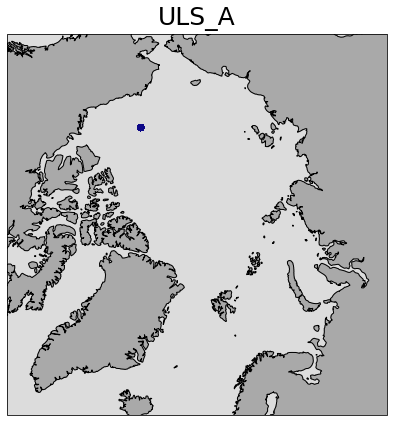

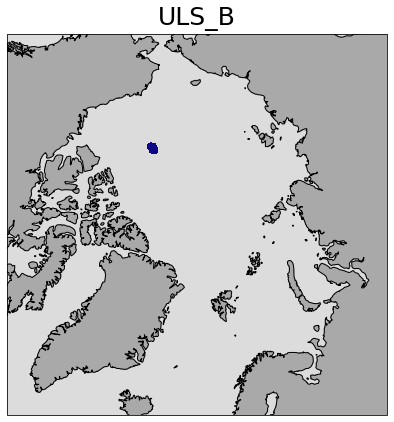

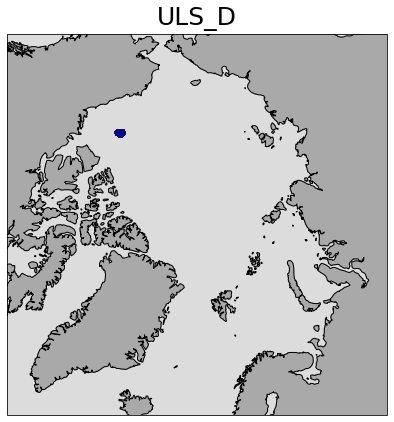

In [12]:
buoys = ['ULS_A','ULS_B','ULS_D']

for counter,buoy in enumerate(buoys):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.coastlines()  
    file = Dataset(datapath+'ERA5_wind_'+buoy+'.nc')
    temp = np.array(file['Wind Speed'])
    lons = np.array(file['Longitude'])
    lats = np.array(file['Latitude'])    
    ax.scatter(lons,lats,c=temp,cmap='plasma',vmin=200,vmax=300,transform=ccrs.PlateCarree())
    ax.set_title(buoy,fontsize=25, pad=10)
    plt.show()